# arXiv heatmap
### Usage stats analysis

In this notebook, we analyze the data about usage to see whether usage depends on the day of the week.  If the data shows such seasonality, we should take that into account when making posting recommendations.  Note that the usage is measured as number of connections per day: while this is not an exact measure of audience size, it is still the only reasonable proxy we can find at the moment.

### Dataset preparation
We start by loading the dataset collected in `data-collection.ipynb`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

usage = pd.read_parquet("../../data/arxiv-usage.parquet")

In [2]:
usage

,1
0,
2024-01-01,43626111
2024-01-02,54640750
2024-01-03,56101036
2024-01-04,50084378
2024-01-05,48182775
...,...
2025-04-06,42500085
2025-04-07,57708551
2025-04-08,57728496


Then we create a new column containing the day of the week for each entry.

In [3]:
from calendar import day_name

usage.reset_index(inplace=True)
usage["weekday"] = usage["0"].apply(lambda date: day_name[date.weekday()])
usage.rename(columns={"0": "date", 1: "connections"}, inplace=True)

In [4]:
usage

,date,connections,weekday
0,2024-01-01,43626111,Monday
1,2024-01-02,54640750,Tuesday
2,2024-01-03,56101036,Wednesday
3,2024-01-04,50084378,Thursday
4,2024-01-05,48182775,Friday
...,...,...,...
461,2025-04-06,42500085,Sunday
462,2025-04-07,57708551,Monday
463,2025-04-08,57728496,Tuesday
464,2025-04-09,56104215,Wednesday


### Exploratory analysis

We start with a violin plot of the training dataset, split by day of the week.

<Axes: xlabel='weekday', ylabel='connections'>

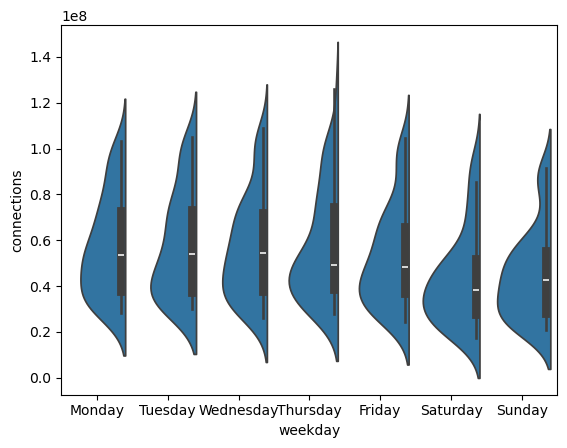

In [5]:
sns.violinplot(
    data=usage,
    x="weekday",
    y="connections",
    # hue=True,
    # hue_order=[True, False],
    split=True,
)

It does not look like the date of the week matters much for the number of connections, possibly except for weekends.  Preprints are made public ("announced") on weekdays only, so it seems reasonable to restrict the dataset to weekdays.

<Axes: xlabel='weekday', ylabel='connections'>

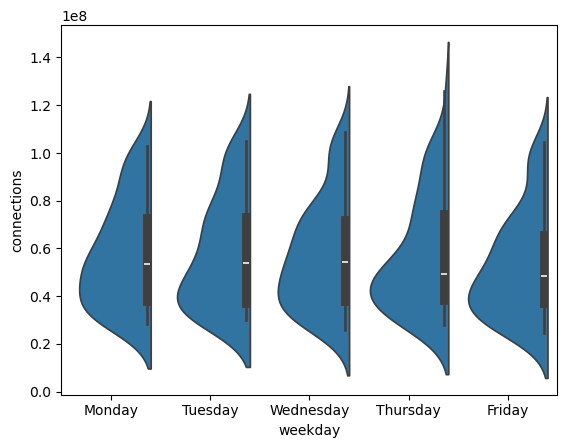

In [6]:
usage_weekdays = usage[(usage.weekday != "Saturday") & (usage.weekday != "Sunday")]
sns.violinplot(
    data=usage_weekdays,
    x="weekday",
    y="connections",
    # hue=True,
    # hue_order=[True, False],
    split=True,
)

We now do hypothesis testing:
- _null hypothesis_: there is no contribution from the day of the week, so the model is average plus noise,
- _alternative hypothesis_: the day of the week has a contribution, so the model is linear regression on 5 one-hot encoded variables.

First, we produce the one-hot encoding of the `weekday` feature.

In [7]:
one_hot = (
    pd.get_dummies(usage_weekdays.weekday, dtype=int)
    .drop("Friday", axis=1)
    .iloc[:, [0, 2, 3, 1]]
)
usage_weekdays = usage_weekdays.join(one_hot)

Then we use `statsmodels` to compare the model with no feature with the model regressed on `Monday`, `Tuesday`, `Wednesday`, and `Friday`, by computing the F-test p-value.

In [8]:
import statsmodels.formula.api as smf

data = {
    "C": usage_weekdays.connections,
    "M": usage_weekdays.Monday,
    "Tu": usage_weekdays.Tuesday,
    "W": usage_weekdays.Wednesday,
    "Th": usage_weekdays.Thursday,
}

reduced_model = smf.ols("C ~ 1", data=data).fit()
full_model = smf.ols("C ~ M + Tu + W + Th", data=data).fit()

f_test = full_model.compare_f_test(reduced_model)
print("F-test p-value:", f_test[1])

F-test p-value: 0.7064791000262229


Hence, if the usage data was generated by a normal probability distribution centered at the average number of connections ($C = C_0 + \varepsilon$), we would see this much improvement when we fit $C = M + Tu + W + Th + \varepsilon$ instead about $77 \%$ of the time.  This is not at all a rare thing to happen, so is evidence supporting the independence of the number of connections on the day of the week.

In [9]:
reduced_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      C   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 05 Jun 2025   Prob (F-statistic):                nan
Time:                        11:19:44   Log-Likelihood:                -6126.2
No. Observations:                 334   AIC:                         1.225e+04
Df Residuals:                     333   BIC:                         1.226e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.661e+07   1.23e+06     46.185      0.000    5.42e+07     5.9e+07
==============================================================================
Omnibus:                       28.294   Durbin-Watson:                   0.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.649
Skew:                           0.647   Prob(JB):                     9.91e-07
Kurtosis:                       2.441   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note that the number of connections seems to depend on some other seasonal feature, but if we limit our forecasting to the week then they don't appear to be relevant.

<Axes: xlabel='Date', ylabel='Connections'>

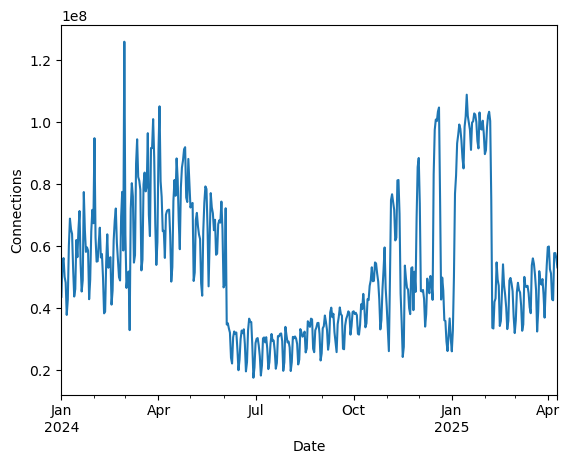

In [10]:
pd.read_parquet("../../data/arxiv-usage.parquet").plot(
    xlabel="Date", ylabel="Connections", legend=False
)